In [113]:
# Parte 1: Preparación del entorno
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

In [114]:
# Parte 2: Carga y análisis exploratorio de los datos
df = pd.read_excel('../Dataset/citaschallenge.xlsx')


print(df.head())
print(df.info())
print(df.describe())



     GENERO  EDAD         ESPECIALIDAD TIPO_AFILIACION          FECHA_CITA  \
0  FEMENINO  41.0           ORTODONCIA            GOLD 2013-07-02 06:30:00   
1  FEMENINO  49.0  TERAPIA OCUPACIONAL          SILVER 2013-07-02 06:30:00   
2  FEMENINO  41.0         FISIOTERAPIA            GOLD 2013-07-02 06:30:00   
3  FEMENINO  49.0         FISIOTERAPIA            GOLD 2013-07-02 06:50:00   
4  FEMENINO  36.0           RADIOLOGIA            GOLD 2013-07-02 06:50:00   

      id  ESTAFINAL  
0   9373          3  
1  62884          2  
2  72568          2  
3   5733          1  
4  22397          3  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67650 entries, 0 to 67649
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   GENERO           67650 non-null  object        
 1   EDAD             67650 non-null  float64       
 2   ESPECIALIDAD     67650 non-null  object        
 3   TIPO_AFILIACION  6765

In [115]:
# --------------------------
# LIMPIEZA DE DATOS
# --------------------------

# 1. Verificar valores nulos en el dataset
print("Valores nulos en cada columna:")
print(df.isnull().sum())

# 2. Convertir columnas categóricas a numéricas
df['GENERO'] = df['GENERO'].str.upper().map({'FEMENINO': 0, 'MASCULINO': 1}).astype(int)
df['EDAD'] = df['EDAD'].astype(int)    
df['TIPO_AFILIACION'] = df['TIPO_AFILIACION'].str.upper().map({'CONVENIO': 1, 'SILVER': 2,'GOLD': 3}).astype(int)   

print(df.info())



Valores nulos en cada columna:
GENERO             0
EDAD               0
ESPECIALIDAD       0
TIPO_AFILIACION    0
FECHA_CITA         0
id                 0
ESTAFINAL          0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67650 entries, 0 to 67649
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   GENERO           67650 non-null  int64         
 1   EDAD             67650 non-null  int64         
 2   ESPECIALIDAD     67650 non-null  object        
 3   TIPO_AFILIACION  67650 non-null  int64         
 4   FECHA_CITA       67650 non-null  datetime64[ns]
 5   id               67650 non-null  int64         
 6   ESTAFINAL        67650 non-null  int64         
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 3.6+ MB
None


In [116]:
# 4. Detección de valores duplicados
print(f"\nCantidad de filas duplicadas: {df.duplicated().sum()}")


Cantidad de filas duplicadas: 0


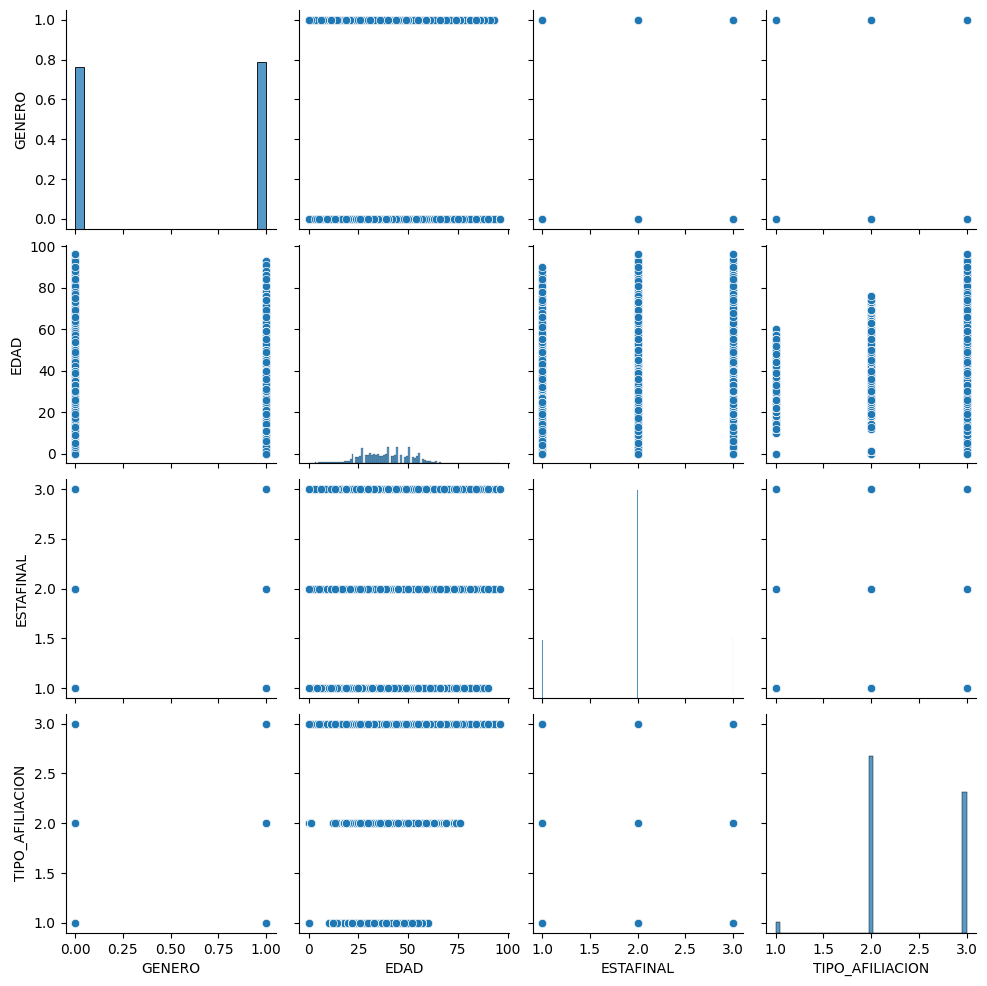

In [117]:
# Visualización de la distribución
sns.pairplot(df[['GENERO', 'EDAD', 'ESTAFINAL','TIPO_AFILIACION']])
plt.show()

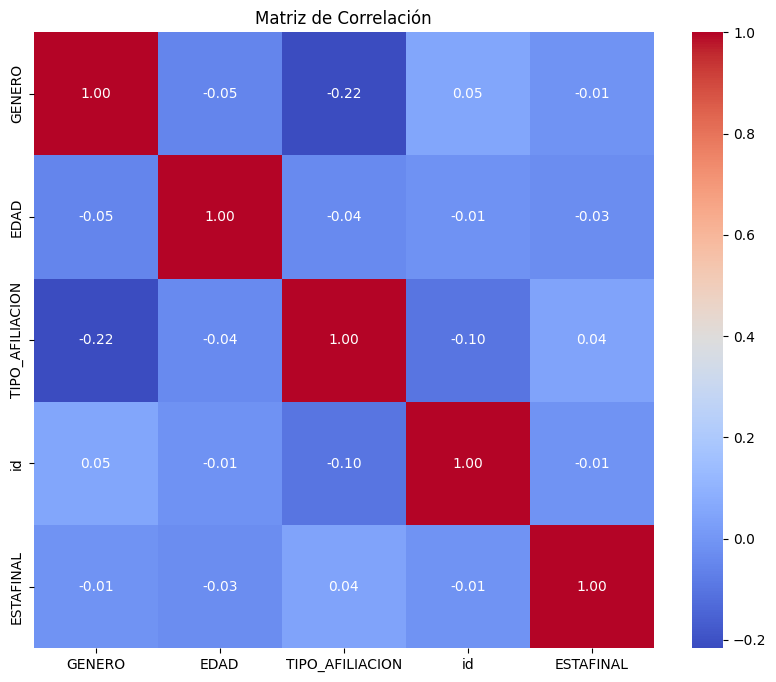

In [118]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación')
plt.show()

In [119]:
# Parte 3: Preprocesamiento
X = df[['GENERO', 'EDAD', 'ESTAFINAL','TIPO_AFILIACION']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

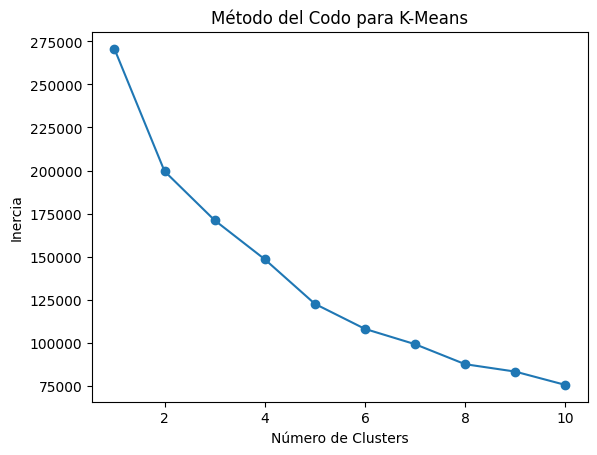

Para k=2, el Silhouette Score es: 0.3017
Para k=3, el Silhouette Score es: 0.3151
Para k=4, el Silhouette Score es: 0.3437
Para k=5, el Silhouette Score es: 0.3695
Para k=6, el Silhouette Score es: 0.3850


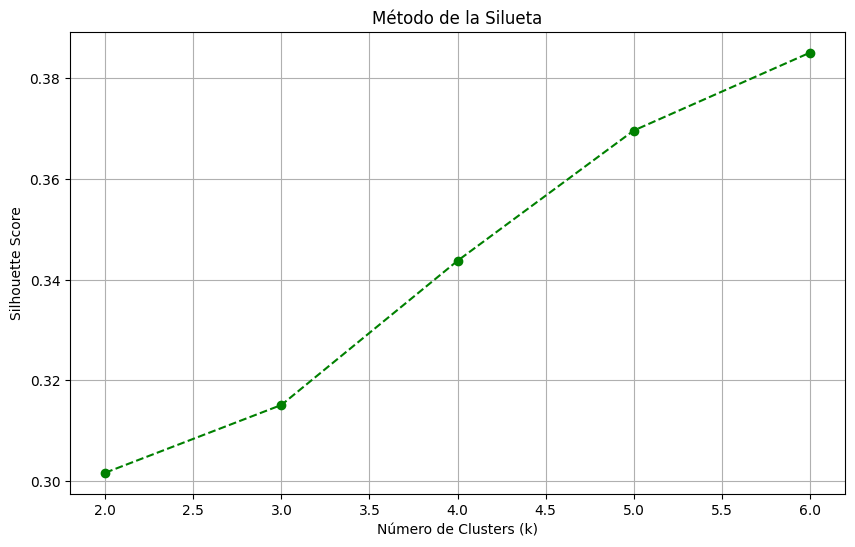

In [120]:
# Parte 4.1: Clustering con K-Means
inertia = []
k_range = range(1, 11)
for k in k_range:
    km = KMeans(n_clusters=k,n_init='auto', random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

# Método del Codo
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Número de Clusters') # Numero de grupos
plt.ylabel('Inercia') # la suma de las distancias cuadradas de cada punto a su centroide (cuánto error hay dentro de cada cluster).
plt.title('Método del Codo para K-Means')
plt.show()

# Metodo Silhouette para determinar el número óptimo de clusters

X_sample = X_scaled[:10000] 

silhouette_scores = []
k_range = range(2, 7) # La silueta no está definida para k=1

for k in k_range:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(X_sample)
    
    # Calculamos el score promedio
    score = silhouette_score(X_sample, labels)
    silhouette_scores.append(score)
    print(f"Para k={k}, el Silhouette Score es: {score:.4f}")

# 2. Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='o', linestyle='--', color='green')
plt.title('Método de la Silueta')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()



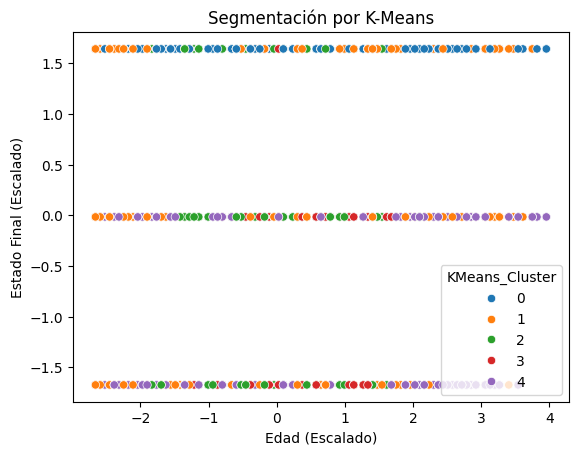

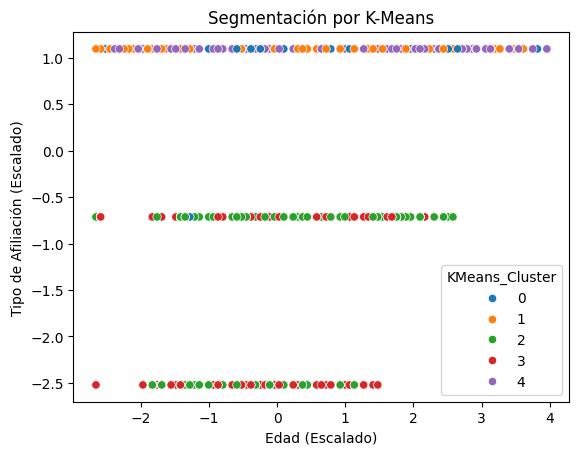

In [121]:
# Ajuste del modelo con K = 5
kmeans = KMeans(n_clusters=5, random_state=42)
df['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)

sns.scatterplot(x=X_scaled[:, 1], y=X_scaled[:, 2], hue=df['KMeans_Cluster'], palette='tab10')
plt.xlabel('Edad (Escalado)')
plt.ylabel('Estado Final (Escalado)')
plt.title('Segmentación por K-Means')
plt.show()

sns.scatterplot(x=X_scaled[:, 1], y=X_scaled[:, 3], hue=df['KMeans_Cluster'], palette='tab10')
plt.xlabel('Edad (Escalado)')
plt.ylabel('Tipo de Afiliación (Escalado)')
plt.title('Segmentación por K-Means')
plt.show()

In [122]:
# Parte 4.1.1: Interpretación de Clustering con K-Means
df.groupby('KMeans_Cluster')[['GENERO', 'EDAD', 'ESTAFINAL','TIPO_AFILIACION']].mean()

,GENERO,EDAD,ESTAFINAL,TIPO_AFILIACION
KMeans_Cluster,,,,
0,0.0,37.418901,3.000000,2.723223
1,1.0,36.654763,2.045555,3.000000
2,1.0,38.355305,1.985533,1.964561
3,0.0,41.398358,1.832369,1.889132
4,0.0,38.365549,1.698955,3.000000


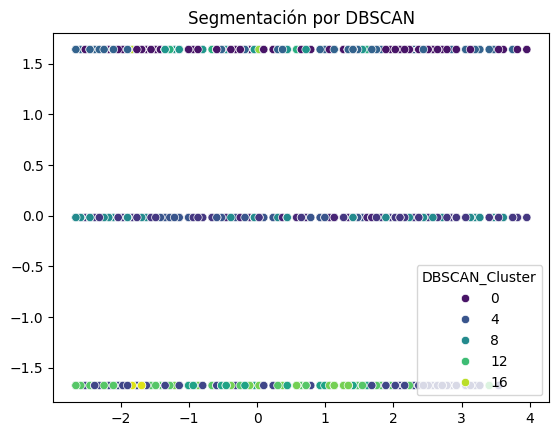

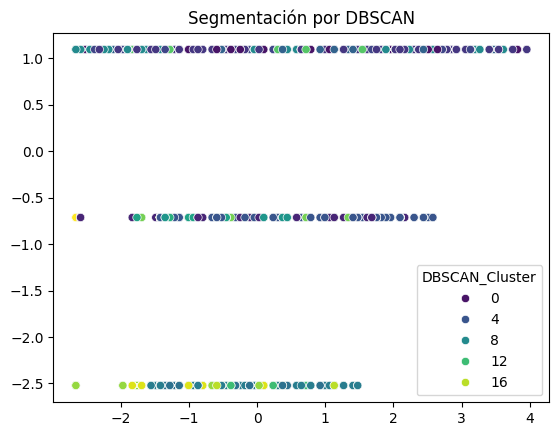

In [123]:
# Parte 4.2: Clustering con DBSCAN
dbscan = DBSCAN(eps=1.0, min_samples=5) # eps = radio máximo para considerar que dos puntos están “cerca”./ min_samples =  número mínimo de puntos vecinos necesarios para formar un cluster.
df['DBSCAN_Cluster'] = dbscan.fit_predict(X_scaled)

sns.scatterplot(x=X_scaled[:, 1], y=X_scaled[:, 2], hue=df['DBSCAN_Cluster'], palette='viridis')
plt.title('Segmentación por DBSCAN')
plt.show()

sns.scatterplot(x=X_scaled[:, 1], y=X_scaled[:, 3], hue=df['DBSCAN_Cluster'], palette='viridis')
plt.title('Segmentación por DBSCAN')
plt.show()

In [124]:
# Parte 4.2.1: Interpretando los Clustering con DBSCAN
df['DBSCAN_Cluster'].value_counts()
df.groupby('DBSCAN_Cluster')[['GENERO', 'EDAD', 'ESTAFINAL','TIPO_AFILIACION']].mean()

,GENERO,EDAD,ESTAFINAL,TIPO_AFILIACION
DBSCAN_Cluster,,,,
-1,0.0,0.000000,1.0,1.0
0,0.0,36.265397,3.0,3.0
1,0.0,42.490899,2.0,2.0
2,0.0,38.458612,2.0,3.0
3,0.0,38.149478,1.0,3.0
4,1.0,39.224206,2.0,2.0
5,1.0,35.689082,3.0,3.0
6,1.0,31.924188,2.0,1.0
7,0.0,34.198913,2.0,1.0


In [125]:
# Parte 4.2.1: Interpretando los Clustering con DBSCAN sin atípicos
df_no_noise = df[df['DBSCAN_Cluster'] != -1]
df_no_noise.groupby('DBSCAN_Cluster')[['GENERO', 'EDAD', 'ESTAFINAL','TIPO_AFILIACION']].mean()

,GENERO,EDAD,ESTAFINAL,TIPO_AFILIACION
DBSCAN_Cluster,,,,
0,0.0,36.265397,3.0,3.0
1,0.0,42.490899,2.0,2.0
2,0.0,38.458612,2.0,3.0
3,0.0,38.149478,1.0,3.0
4,1.0,39.224206,2.0,2.0
5,1.0,35.689082,3.0,3.0
6,1.0,31.924188,2.0,1.0
7,0.0,34.198913,2.0,1.0
8,1.0,37.782759,2.0,3.0


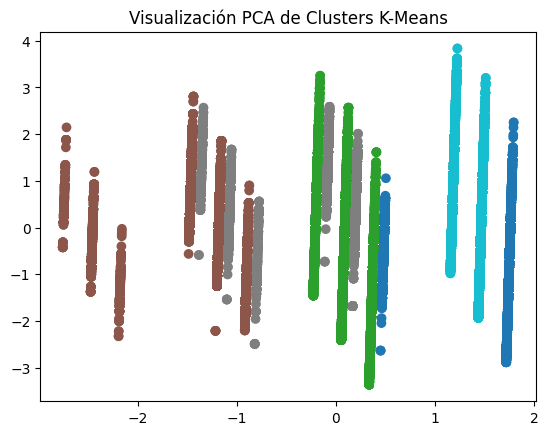

In [126]:
# Parte 5.1: Reducción de dimensionalidad con PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['KMeans_Cluster'], cmap='tab10')
plt.title('Visualización PCA de Clusters K-Means')
plt.show()



In [127]:
# Parte 5.1.1: Interpretación de Reducción de dimensionalidad con PCA
df.groupby('KMeans_Cluster')[['GENERO', 'EDAD', 'ESTAFINAL','TIPO_AFILIACION']].mean()

,GENERO,EDAD,ESTAFINAL,TIPO_AFILIACION
KMeans_Cluster,,,,
0,0.0,37.418901,3.000000,2.723223
1,1.0,36.654763,2.045555,3.000000
2,1.0,38.355305,1.985533,1.964561
3,0.0,41.398358,1.832369,1.889132
4,0.0,38.365549,1.698955,3.000000


In [128]:
# Parte 5.1.2: Interpretación detallada de Reducción de dimensionalidad con PCA
# Mostrar algunos usuarios por cluster
for i in range(4):
    print(f"\nCluster {i}")
    display(df[df['KMeans_Cluster'] == i][['GENERO', 'EDAD', 'ESTAFINAL','TIPO_AFILIACION']].head())


Cluster 0


,GENERO,EDAD,ESTAFINAL,TIPO_AFILIACION
0,0,40,3,3
4,0,36,3,3
5,0,39,3,3
10,0,8,3,3
18,0,31,3,3



Cluster 1


,GENERO,EDAD,ESTAFINAL,TIPO_AFILIACION
13,1,37,3,3
17,1,55,2,3
26,1,45,2,3
73,1,30,2,3
81,1,60,3,3



Cluster 2


,GENERO,EDAD,ESTAFINAL,TIPO_AFILIACION
9,1,50,2,2
12,1,27,2,2
14,1,45,2,1
20,1,29,2,2
22,1,25,3,2



Cluster 3


,GENERO,EDAD,ESTAFINAL,TIPO_AFILIACION
1,0,49,2,2
8,0,31,2,2
15,0,45,2,1
19,0,48,2,2
21,0,50,2,2


C:\Users\andre\AppData\Local\Temp\ipykernel_2352\738117817.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='KMeans_Cluster', y='EDAD', data=df, palette='tab10')


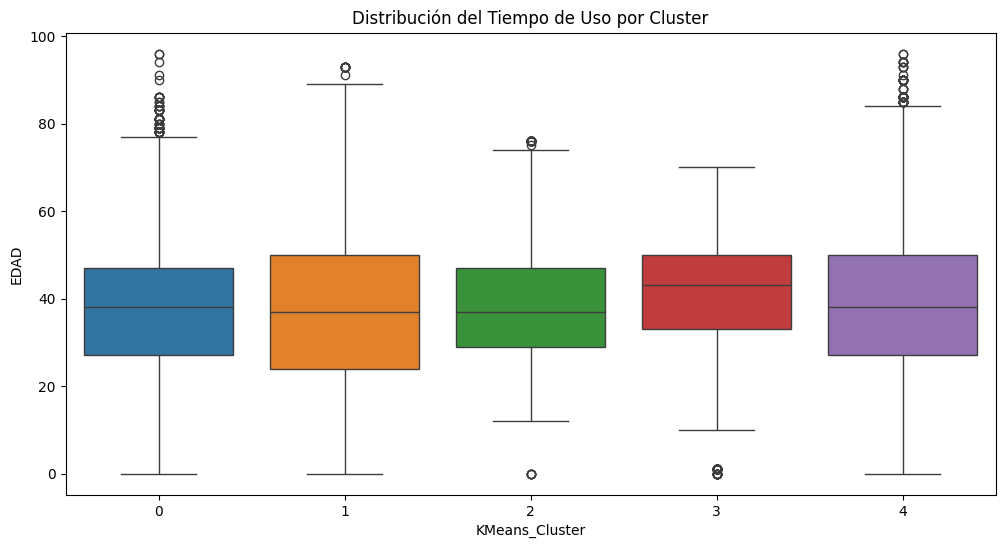

In [129]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='KMeans_Cluster', y='EDAD', data=df, palette='tab10')
plt.title('Distribución del Tiempo de Uso por Cluster')
plt.show()

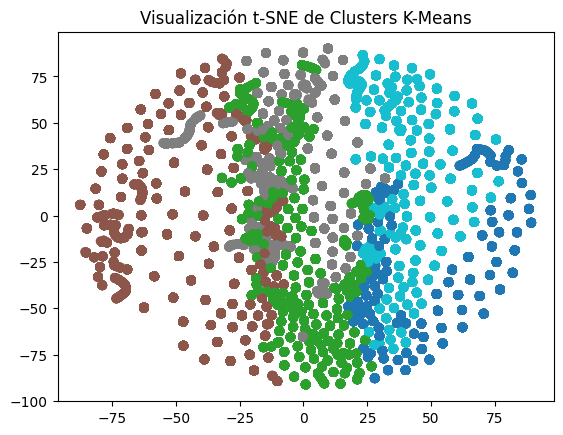

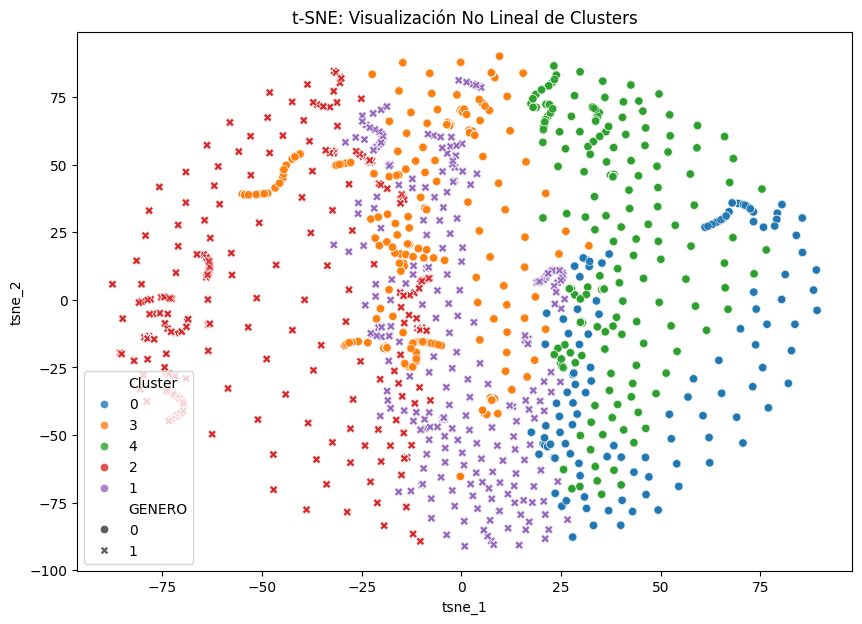

In [ ]:

# El prcesamiento tsne puede tardar varios minutos, dependiendo del tamaño del dataset y de los parámetros elegidos. Si el dataset es muy grande
tsne = TSNE(n_components=2 ,method='barnes_hut', n_jobs=-1, perplexity=30, learning_rate=200, random_state=42) # cuántos vecinos cercanos considera t-SNE / cuánto se mueven los puntos
X_tsne = tsne.fit_transform(X_scaled)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df['KMeans_Cluster'], cmap='tab10')
plt.title('Visualización t-SNE de Clusters K-Means')
plt.savefig('../Results/t-SNE - K-Means.png')
plt.show()
# Creamos un DataFrame para t-SNE
df_tsne = pd.DataFrame(X_tsne, columns=['tsne_1', 'tsne_2'])
df_tsne['Cluster'] = df['KMeans_Cluster'].astype(str)
df_tsne['GENERO'] = df['GENERO']

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df_tsne, x='tsne_1', y='tsne_2', 
    hue='Cluster', style='GENERO', 
    palette='tab10', alpha=0.8
)
plt.title('t-SNE: Visualización No Lineal de Clusters')
plt.savefig('../Results/t-SNE-Genero.png')
plt.show()

In [131]:
# Parte 5.2.1: Interpretación de Reducción de dimensionalidad con t-SNE
df.groupby('KMeans_Cluster')[['GENERO', 'EDAD', 'ESTAFINAL','TIPO_AFILIACION']].mean()

,GENERO,EDAD,ESTAFINAL,TIPO_AFILIACION
KMeans_Cluster,,,,
0,0.0,37.418901,3.000000,2.723223
1,1.0,36.654763,2.045555,3.000000
2,1.0,38.355305,1.985533,1.964561
3,0.0,41.398358,1.832369,1.889132
4,0.0,38.365549,1.698955,3.000000


In [132]:
# Parte 6: Análisis
print("Clusters únicos KMeans:", df['KMeans_Cluster'].unique())
print("Clusters únicos DBSCAN:", df['DBSCAN_Cluster'].unique())

Clusters únicos KMeans: [0 3 4 2 1]
Clusters únicos DBSCAN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 -1 18]
